# NDA_COURSEWORK Part 1

In [2]:
# importing the necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

import ndlib.models.epidemics.SIRModel as sir
import ndlib.models.ModelConfig as config

## Task A: Network Construction

### Step 1: Load Dataset  
This function reads a CSV file containing the Wikidata Talk page dataset into a pandas DataFrame. Each row corresponds to a user comment on a thread within a page.

In [ ]:
def load_dataset(file_path):
    data_set = pd.read_csv(file_path) # reads a csv file in a pandas dataframe
    return data_set

### Step 2: Assign Unique Node IDs  
Each unique username is assigned a numerical ID to use in the graph structure. This is helpful for efficiency in graph construction and analysis.

In [ ]:
def assign_node_ids(df):
    unique_users = df["username"].unique() # getting unique users from data frame
    # Returns a dictionary, containing a Mapping of username to unique integer node ID.
    return {user: ids for ids, user in enumerate(unique_users)}

### Step 3: Construct the Editor Network  
This function creates an undirected graph where nodes are users. An edge is added between two users if they commented on the same thread_subject of the same page_name. It also attaches the following attributes to each Node:

- Username

- Total comments

- Number of unique pages

- Number of unique threads.

In [ ]:
def construct_wikidata_editor_network(df, user_id_map):
    G = nx.Graph()

    # Counting the total number of comments per user
    user_comment_counts = df["username"].value_counts().to_dict()

    # Storing the number of unique pages and threads per user
    user_pages = df.groupby("username")["page_name"].nunique().to_dict()
    user_threads = df.groupby("username")["thread_subject"].nunique().to_dict()

    # Creating an empty adjacency list to store connections
    adjacency = {}

    # Grouping by page_name and thread_subject to find users interacting in the same thread
    grouped_users = df.groupby(["page_name", "thread_subject"])["username"]
            
    # Iterating over each group of users who commented in the same thread and page
    for _, users in grouped_users:
        users = set(users)  # Converting to set to remove any duplicates
        
        for user in users:
            # Initializing adjacency list for the user if not already present
            if user not in adjacency:
                adjacency[user] = set()
            
            # Adding all other users in the same thread as neighbors, This creates undirected edges 
            # between all people who commented in the same thread
            adjacency[user].update(users - {user}) # subtracting user to exclude self from adjacency
    
    

    # Adding nodes and edges to the graph with attributes
    for user, neighbors in adjacency.items():
        G.add_node(user_id_map[user],
                username=user, 
                total_comments=user_comment_counts.get(user, 0),
                unique_pages=user_pages.get(user, 0),
                unique_threads=user_threads.get(user, 0)
                )
        for neighbor in neighbors:
            G.add_edge(user_id_map[user], user_id_map[neighbor])
    
    return G


### Step 4: Visualize the Network  
This function plots the constructed editor network. Nodes represent editors, and edges indicate co-participation in the same thread on a page.

In [6]:
def visualize_network(G, title=""):
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(G, seed=42)  # Positioning nodes
        nx.draw(G, 
                pos,
                node_size=50,                  
                node_color="skyblue",   # Fill color
                edge_color="black",     # Edge color
                edgecolors="black",     # Node border color
                alpha=0.6,
                with_labels=False
        )
        plt.title(title)
        plt.show()

### Step 5: Interactive Network Visualization  
This function uses Bokeh to render an interactive version of the editor network implemented in Lab 2 of NDA. You can zoom, pan, and inspect the graph dynamically in the browser.

In [7]:
from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import figure, from_networkx
output_notebook()
from bokeh.palettes import Spectral4
from bokeh.models import (
    Plot, Range1d, Circle, MultiLine, 
    HoverTool, TapTool, BoxZoomTool, WheelZoomTool, 
    PanTool, ResetTool, NodesAndLinkedEdges, EdgesAndLinkedNodes
)

def interactive_network_plot(G, title=""):
    plot = Plot(width=800, height=400,
                x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
    plot.title.text = title

    # Add interactive tools
    plot.add_tools(
        HoverTool(tooltips=None),
        TapTool(), BoxZoomTool(), WheelZoomTool(),
        PanTool(), ResetTool()
    )

    # Use a spring layout
    graph_renderer = from_networkx(G, nx.spring_layout, scale=2, center=(0, 0))

    # Style nodes
    graph_renderer.node_renderer.glyph = Circle(radius=0.008, fill_color=Spectral4[0])
    graph_renderer.node_renderer.selection_glyph = Circle(radius=0.015, fill_color=Spectral4[2])
    graph_renderer.node_renderer.hover_glyph = Circle(radius=0.008, fill_color=Spectral4[1])

    # Style edges
    graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=1)
    graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=1)
    graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=1)

    # Define interaction behavior
    graph_renderer.selection_policy = NodesAndLinkedEdges()
    graph_renderer.inspection_policy = EdgesAndLinkedNodes()

    # Add graph to plot
    plot.renderers.append(graph_renderer)

    # Display the plot
    show(plot)

Loading BokehJS ...

### Step 6: Construct and Visualize Small, Medium, and Large Wikidata Editor Networks

We construct three user interaction networks based on file sizes:
- **Small**: `BOT_REQUESTS.csv`
- **Medium**: `ITEMS.csv`
- **Large**: `REQUEST_FOR_DELETION.csv`

Each dataset is loaded, processed into a network graph, and visualized using both static and interactive visualizations.

#### 6.1 Constructing and Visualizing Small Size Network

In [8]:
small_size_data_frame = load_dataset("../data/part1/BOT_REQUESTS.csv") # This file is selected because it had the smallest size.
user_id_map = assign_node_ids(small_size_data_frame) # Assigning node ids
small_size_graph_network= construct_wikidata_editor_network(small_size_data_frame,user_id_map) # constructing small size network

##### Inspecting Node Attributes
To verify the construction of the network and the assignment of node attributes , we print the attributes of the first 5 nodes in the small-sized network.

In [9]:
count = 0
for node, attrs in small_size_graph_network.nodes(data=True):
    print(f"Node ID: {node}, Attributes: {attrs}")
    count += 1
    if count >= 5:
        break

Node ID: 322, Attributes: {'username': 'Epìdosis', 'total_comments': 16, 'unique_pages': 9, 'unique_threads': 16}
Node ID: 546, Attributes: {'username': 'item wikibase:statements 0 ; wikibase:sitelinks 1 } }}\n\n(2) There are 1003096 items (including actual sitelinks) on', 'total_comments': 1, 'unique_pages': 1, 'unique_threads': 1}
Node ID: 505, Attributes: {'username': 'Haansn08', 'total_comments': 1, 'unique_pages': 1, 'unique_threads': 1}
Node ID: 507, Attributes: {'username': 'Anonymous_username_64', 'total_comments': 1, 'unique_pages': 1, 'unique_threads': 1}
Node ID: 504, Attributes: {'username': 'Laurentius', 'total_comments': 1, 'unique_pages': 1, 'unique_threads': 1}


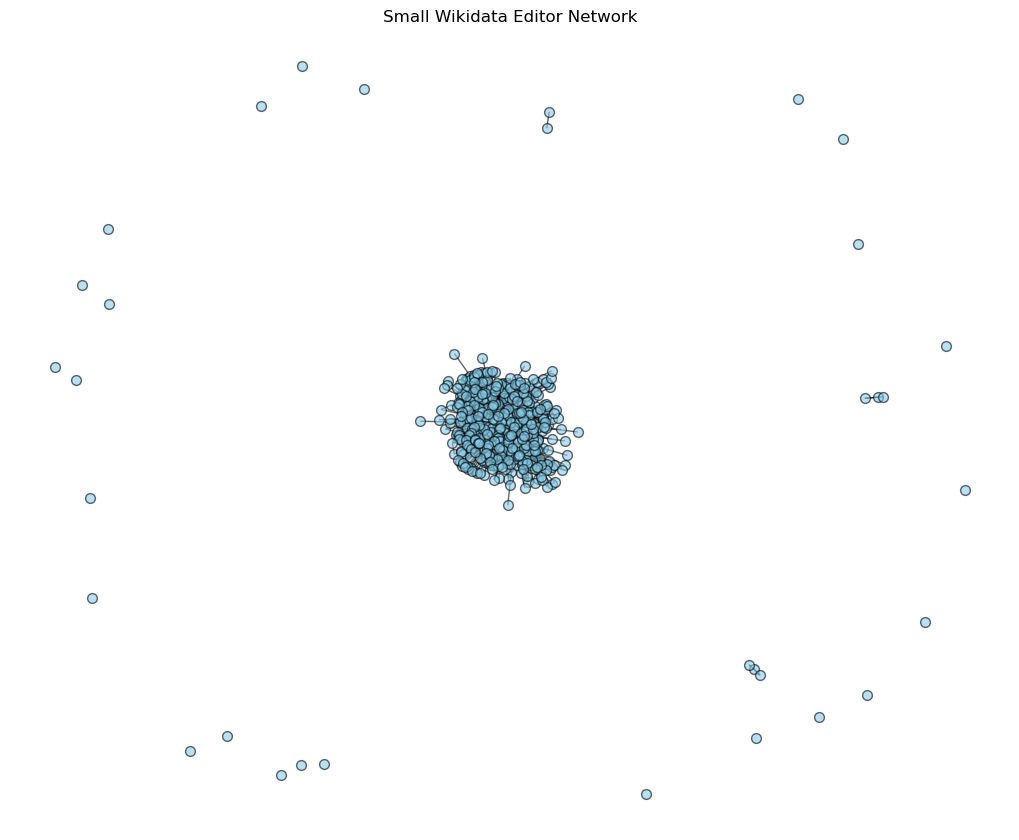

In [10]:
visualize_network(small_size_graph_network, "Small Wikidata Editor Network")

In [11]:
interactive_network_plot(small_size_graph_network, "Small Wikidata Editor Network") # Drag to view entire network

#### 6.2 Constructing and Visualizing Medium Size Network

In [12]:
medium_size_data_frame = load_dataset("../data/part1/ITEMS.csv") # This file was selected because it had size in between the largest and smallest file
user_id_map = assign_node_ids(medium_size_data_frame) # Assigning node ids
medium_size_graph_network= construct_wikidata_editor_network(medium_size_data_frame,user_id_map) # constructing medium size network

##### Inspecting Node Attributes
To verify the construction of the network and the assignment of node attributes , we print the attributes of the first 5 nodes in the medium-sized network.

In [13]:
count = 0
for node, attrs in medium_size_graph_network.nodes(data=True):
    print(f"Node ID: {node}, Attributes: {attrs}")
    count += 1
    if count >= 5:
        break

Node ID: 2875, Attributes: {'username': 'Jacob&#39;s Crackers', 'total_comments': 1, 'unique_pages': 1, 'unique_threads': 1}
Node ID: 105, Attributes: {'username': 'Infovarius', 'total_comments': 1091, 'unique_pages': 1023, 'unique_threads': 536}
Node ID: 4238, Attributes: {'username': 'Rgvis', 'total_comments': 1, 'unique_pages': 1, 'unique_threads': 1}
Node ID: 1923, Attributes: {'username': 'ToprakM', 'total_comments': 4, 'unique_pages': 4, 'unique_threads': 4}
Node ID: 1812, Attributes: {'username': 'Giftzwerg 88', 'total_comments': 11, 'unique_pages': 11, 'unique_threads': 6}


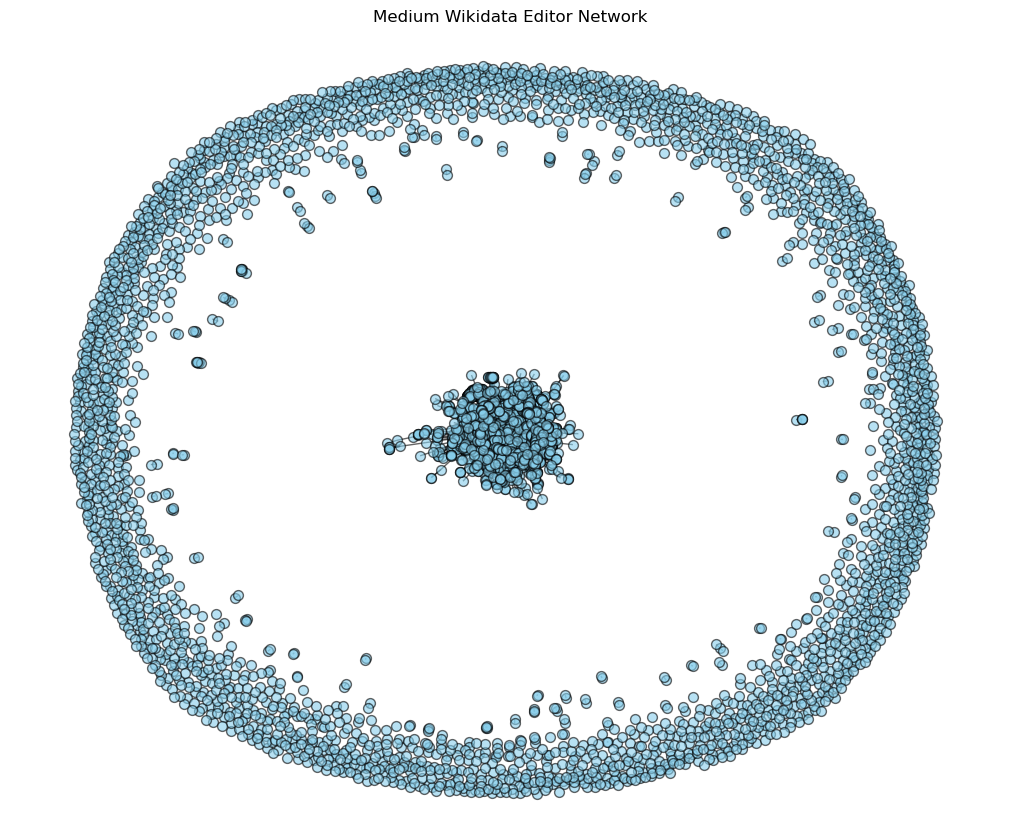

In [14]:
visualize_network(medium_size_graph_network, "Medium Wikidata Editor Network")

In [15]:
interactive_network_plot(medium_size_graph_network, "Medium Wikidata Editor Network") # Drag to view entire network

#### 6.3 Constructing and Visualizing Large Size Network

In [16]:
large_size_data_frame = load_dataset("../data/part1/REQUEST_FOR_DELETION.csv") # This file is selected because it had the largest size.
user_id_map = assign_node_ids(large_size_data_frame) # Assigning node ids
large_size_graph_network= construct_wikidata_editor_network(large_size_data_frame,user_id_map) # constructing large size network

##### Inspecting Node Attributes
To verify the construction of the network and the assignment of node attributes , we print the attributes of the first 5 nodes in the large-sized network.

In [17]:
count = 0
for node, attrs in large_size_graph_network.nodes(data=True):
    print(f"Node ID: {node}, Attributes: {attrs}")
    count += 1
    if count >= 5: 
        break

Node ID: 4710, Attributes: {'username': 'Richard Arthur Norton (1958- )', 'total_comments': 165, 'unique_pages': 89, 'unique_threads': 158}
Node ID: 9858, Attributes: {'username': '2003:DA:1707:C869:28A3:78A5:7ADD:31BB', 'total_comments': 1, 'unique_pages': 1, 'unique_threads': 1}
Node ID: 425, Attributes: {'username': 'Xezbeth', 'total_comments': 213, 'unique_pages': 87, 'unique_threads': 211}
Node ID: 9857, Attributes: {'username': '2003:DA:1710:9C1A:5965:8DB4:7DE7:1B41', 'total_comments': 1, 'unique_pages': 1, 'unique_threads': 1}
Node ID: 5398, Attributes: {'username': 'Okkn', 'total_comments': 57, 'unique_pages': 42, 'unique_threads': 54}


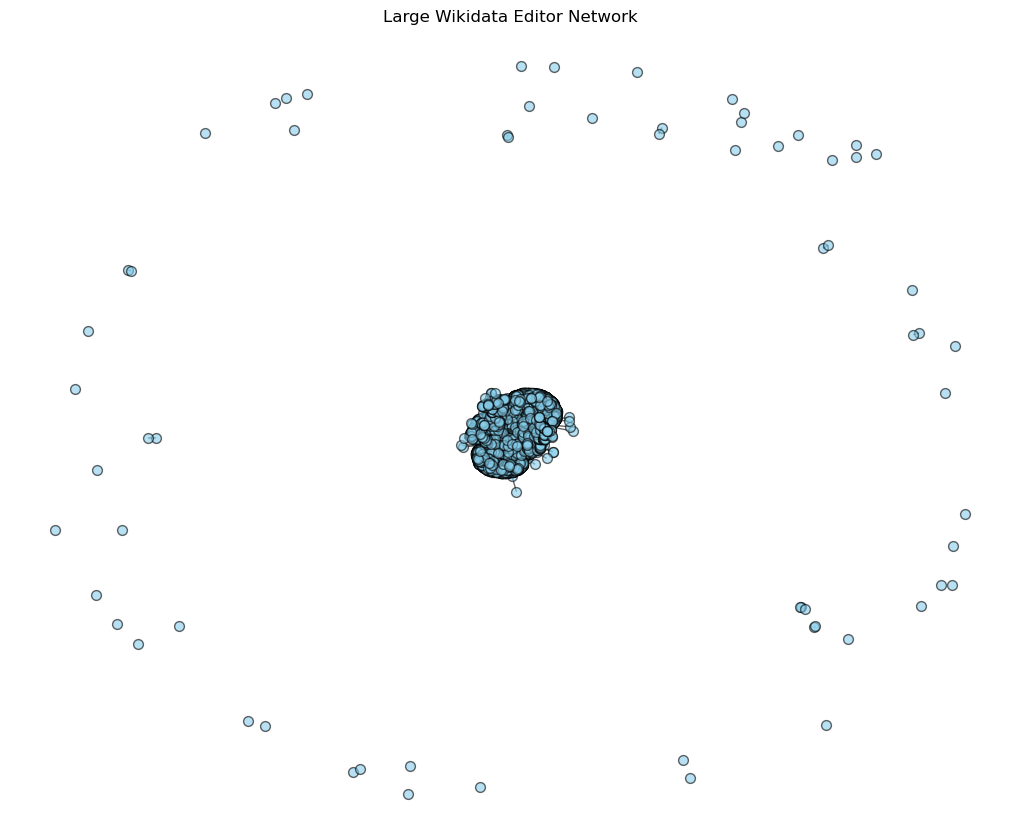

In [18]:
visualize_network(large_size_graph_network, "Large Wikidata Editor Network")

In [19]:
interactive_network_plot(large_size_graph_network, "Large Wikidata Editor Network") # Drag to view entire network

## Task B: Network Metrics

### Computing Network Metrics

This function calculates key structural properties of a given network, as studied in NDA lectures (Week 1-2). These metrics help characterize the Wikidata editor network and allow meaningful comparison with a random baseline.

The computed metrics include:

- **Basic statistics**: Number of nodes, number of edges, average degree  
- **Connectivity properties**: Number of connected components, diameter (of the largest connected component), average shortest path length  
- **Clustering coefficient**: Measures the tendency of nodes to form tightly-knit groups  
- **Centrality measures**:  
  - *Degree Centrality*: Based on the number of direct connections  
  - *Closeness Centrality*: Based on inverse distance to all other nodes  
  - *Betweenness Centrality*: Based on how often a node lies on shortest paths between others



In [42]:

def compute_network_metrics(G):
    metrics = {} 
    
    # Basic network stats
    metrics["num_nodes"] = G.number_of_nodes()
    metrics["num_edges"] = G.number_of_edges()
    
    # Degree-related metrics
    degrees = [deg for _, deg in G.degree()]
    metrics["avg_degree"] = sum(degrees) / len(degrees) if degrees else 0
    metrics["degree_sequence"] = degrees

    # Connected components
    components = list(nx.connected_components(G))
    metrics["num_components"] = len(components)
    
    # Extracting the largest connected component for distance-based metrics
    largest_component = max(components, key=len)
    subgraph = G.subgraph(largest_component)

    # Diameter and average shortest path length on largest connected component 
    try:
        metrics["diameter"] = nx.diameter(subgraph)
        metrics["avg_shortest_path"] = nx.average_shortest_path_length(subgraph)
    except nx.NetworkXError:
        metrics["diameter"] = None
        metrics["avg_shortest_path"] = None

    # Clustering coefficient
    metrics["avg_clustering"] = nx.average_clustering(G)
    
    # Centrality scores (node-level)
    metrics["degree_centrality"] = nx.degree_centrality(G)
    metrics["closeness_centrality"] = nx.closeness_centrality(G)
    metrics["betweenness_centrality"] = nx.betweenness_centrality(G)

    # Sample node
    metrics["sample_node"] = list(G.nodes())[0] if metrics["num_nodes"] > 0 else None
    
    return metrics

### Displaying Network Metrics

This utility function prints out the computed metrics for a given network, It also displays a sample node’s attributes if available.

In [74]:
def display_metrics(metrics, G, label="Original Network"):
    print(f"\n---------------------### {label} Statistics ###---------------------")

    # Basic structural properties
    print(f"Number of nodes: {metrics['num_nodes']}")
    print(f"Number of edges: {metrics['num_edges']}")
    print(f"Number of connected components: {metrics['num_components']}")

    # Path-based properties (only if graph is connected)
    if metrics["diameter"] is not None:
        print(f"Diameter of largest component: {metrics['diameter']}")
        print(f"Average shortest path length: {metrics['avg_shortest_path']:.4f}")
    else:
        print("Graph not connected, so no diameter or average shortest path.")

    # Degree and clustering
    print(f"Average degree: {metrics['avg_degree']:.2f}")
    print(f"Average clustering coefficient: {metrics['avg_clustering']:.4f}")
    
    # Centrality Measures
    print("\nCentrality Measures:")

    # Degree Centrality 
    if "degree_centrality" in metrics:
        degree_scores = list(metrics["degree_centrality"].values())
        degree_scores.sort(reverse=True) # Sorting in descending order
        print("\nDegree Centrality:")
        print([round(score, 5) for score in degree_scores[:10]]) # First 10 scores which are rounded to 5dp

    # Closeness Centrality
    if "closeness_centrality" in metrics:
        closeness_scores = list(metrics["closeness_centrality"].values())
        closeness_scores.sort(reverse=True) # Sorting in descending order
        print("\nCloseness Centrality:")
        print([round(score, 5) for score in closeness_scores[:10]]) # First 10 scores which are rounded to 5dp

    # Betweenness Centrality
    if "betweenness_centrality" in metrics:
        betweenness_scores = list(metrics["betweenness_centrality"].values())
        betweenness_scores.sort(reverse=True) # Sorting in descending order
        print("\nBetweenness Centrality:")
        print([round(score, 5) for score in betweenness_scores[:10]]) # First 10 scores which are rounded to 5dp


    # Display one sample node's metadata
    if metrics["sample_node"] is not None:
        print(f"\nSample Node: {metrics['sample_node']}")
        print("Attributes:", G.nodes[metrics["sample_node"]])
        
    print(f"\n------------------------------------------------------------------------------")

### Generating a Random Network for Comparison

To compare the Wikidata editor network against a baseline, we generate a random graph using the Erdos-Renyi model (`G(n, p)`), where `n` is the number of nodes and `p` is the probability of an edge existing between any two nodes. The probability `p` is calibrated to match the original network’s edge density, ensuring a fair structural comparison.

In [50]:
def generate_random_network(G):
    num_nodes = G.number_of_nodes() # Extracting nodes of the original graph
    num_edges = G.number_of_edges() # Extracting edges of the original graph
    
    # Estimate edge creation probability for Erdos-Renyi model
    prob = num_edges / (num_nodes * num_nodes / 2)
    
    # Generating the Erdos-Renyi random graph
    random_graph = nx.erdos_renyi_graph(n=num_nodes, p=prob)
    return random_graph

### Plotting Degree Distribution

This function visualizes the degree distribution of a network using a histogram. The x-axis represents node degrees, while the y-axis shows the frequency of nodes with each degree. This plot helps reveal the structural properties of the network, such as it follows a heavy-tailed or normal distribution.

In [59]:
def plot_degree_distribution(degrees, label="Original Network"):
        plt.figure()

        # Plotting histogram of degrees
        plt.hist(degrees, bins=range(1, max(degrees)+2), 
                edgecolor='black',
                align='left')

        # Adding titles and labels
        plt.title(f"Degree Distribution: {label}")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Plotting Degree Distribution with Logarithmic Scaling

This function plots the degree distribution of a network using a histogram and allows optional logarithmic scaling on both the x- and y-axes. This is especially useful for large networks where degree values are highly skewed or follow a power-law distribution. 
Also the x-axis can be restricted using the `max_degree` parameter to focus on the lower range of degrees.

In [ ]:
def plot_degree_distribution_logarithmic(degrees, label="Original Network", log_y=False, log_x=False, max_degree=None):
    plt.figure()

    # Define histogram bins (1 per degree value)
    bins = range(1, max(degrees) + 2)
    
    # Plot histogram of degrees
    plt.hist(degrees, bins=bins, edgecolor='black', align='left')

    # Add title and axis labels
    plt.title(f"Degree Distribution: {label}")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")

    # Apply log scale to y-axis if specified
    if log_y:
        plt.yscale("log")

    # Apply log scale to x-axis if specified
    if log_x:
        plt.xscale("log")

    # Limit x-axis range if a maximum degree value is provided
    if max_degree:
        plt.xlim(0, max_degree)

    # Grid and layout for clarity
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Plotting Degree Distributions: Real vs Random Networks

This function plots and compares the degree distributions of the real Wikidata editor network and a corresponding random network generated using the Erdos-Renyi model. Overlapping histograms help visualize how much the structure of the real network deviates from a random one. This is useful for detecting scale-free behavior, heavy-tailed distributions, or small-world properties.

In [68]:
def plot_degree_distribution_comparison(degrees_real, degrees_random, real_label="Original Network", random_label="Random Network"):
        plt.figure()

        # Plotting histogram for real network degrees
        plt.hist(degrees_real,
                alpha=0.6,
                label=real_label,
                bins=30)

        # Plotting histogram for random network degrees
        plt.hist(degrees_random,
                alpha=0.6,
                label=random_label,
                bins=30)

        # Adding titles and labels
        plt.title("Degree Distribution: {label} vs Random Network")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Comparison: Small Wikidata Editor Network vs Small Random Network

We compare the small-sized Wikidata editor network with a random network generated using the Erdos-Renyi model. Both networks have the same number of nodes and approximately the same number of edges.

#### Computing and Displaying Small Wikidata Editor Network Metrics

In [75]:
small_graph_metrics = compute_network_metrics(small_size_graph_network) 
display_metrics(small_graph_metrics, small_size_graph_network, "Small Wikidata Editor Networks" )


---------------------### Small Wikidata Editor Networks Statistics ###---------------------
Number of nodes: 552
Number of edges: 2425
Number of connected components: 29
Diameter of largest component: 6
Average shortest path length: 2.6027
Average degree: 8.79
Average clustering coefficient: 0.6576

Centrality Measures:

Degree Centrality:
[0.41016, 0.35935, 0.27586, 0.17786, 0.17241, 0.14882, 0.14882, 0.12341, 0.12341, 0.11434]

Closeness Centrality:
[0.58885, 0.56559, 0.53869, 0.5078, 0.49742, 0.49041, 0.48649, 0.48215, 0.47837, 0.47096]

Betweenness Centrality:
[0.25815, 0.21438, 0.1419, 0.05762, 0.051, 0.04019, 0.03483, 0.0326, 0.032, 0.03191]

Sample Node: 322
Attributes: {'username': 'Epìdosis', 'total_comments': 16, 'unique_pages': 9, 'unique_threads': 16}

------------------------------------------------------------------------------


Insight Summary: Small Wikidata Editor Network

The small network exhibits strong small-world characteristics — high clustering, short path lengths, and a clear presence of central users. Degree, closeness, and betweenness centralities reveal a few highly influential editors. The structure is well-connected but still fragmented into multiple components.

#### Computing and Displaying Small Random Network Metrics

In [76]:
small_random_network = generate_random_network(small_size_graph_network)
small_random_network_metrics = compute_network_metrics(small_random_network)
display_metrics(small_random_network_metrics, small_random_network, "Small Random Network Statistics")


---------------------### Small Random Network Statistics Statistics ###---------------------
Number of nodes: 552
Number of edges: 2521
Number of connected components: 1
Diameter of largest component: 5
Average shortest path length: 3.0907
Average degree: 9.13
Average clustering coefficient: 0.0172

Centrality Measures:

Degree Centrality:
[0.0363, 0.03448, 0.03448, 0.03267, 0.02904, 0.02904, 0.02904, 0.02904, 0.02904, 0.02904]

Closeness Centrality:
[0.37005, 0.36856, 0.36758, 0.36346, 0.36131, 0.3606, 0.35872, 0.35756, 0.3571, 0.35571]

Betweenness Centrality:
[0.01615, 0.0148, 0.01297, 0.01239, 0.01176, 0.01118, 0.01102, 0.01077, 0.01072, 0.01047]

Sample Node: 0
Attributes: {}

------------------------------------------------------------------------------


Insight Summary: Small Random Network

The random network is fully connected with low clustering and slightly longer paths. Centrality scores are tightly distributed, indicating no highly influential nodes. This structure lacks the hubs and localized clustering seen in the real editor network.

#### Degree Distribution: Small Wikidata Editor Network

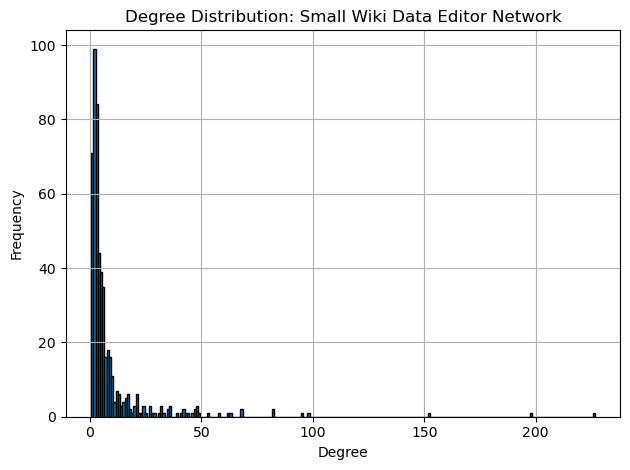

In [78]:
plot_degree_distribution(small_graph_metrics["degree_sequence"],"Small Wiki Data Editor Network")

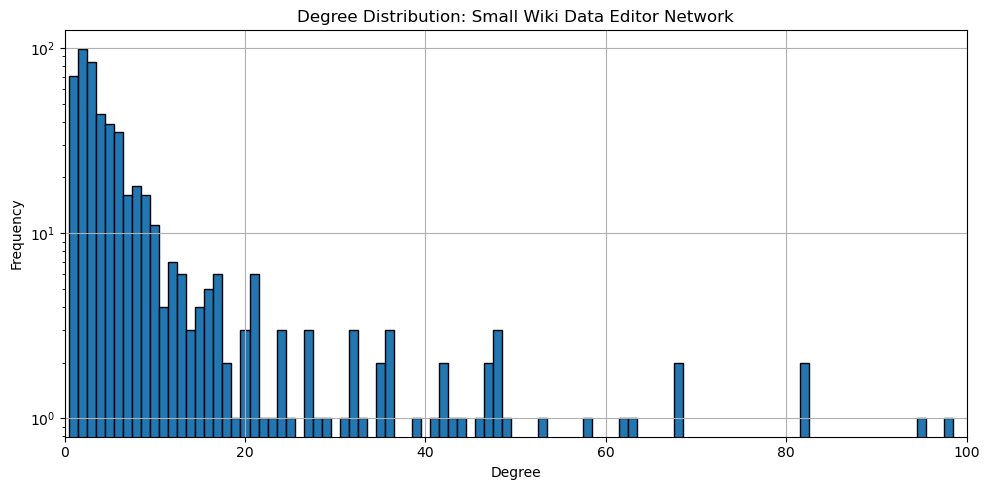

In [107]:
plot_degree_distribution_logarithmic(small_graph_metrics["degree_sequence"],
                        label="Small Wiki Data Editor Network",
                        log_y=True, max_degree=100)

The distribution is highly **right-skewed**, suggesting that while most editors participate in a few discussions, a small number are highly active and connected. This behavior is typical in real-world social networks and may indicate the presence of influential or coordinating users.

The degree distribution follows a **long-tailed pattern**, where most editors have very low degree values, and only a few users act as hubs with very high connectivity. This supports the presence of structural hierarchy or core contributors within the Wikidata Talk pages.

#### Degree Distribution: Small Random Network

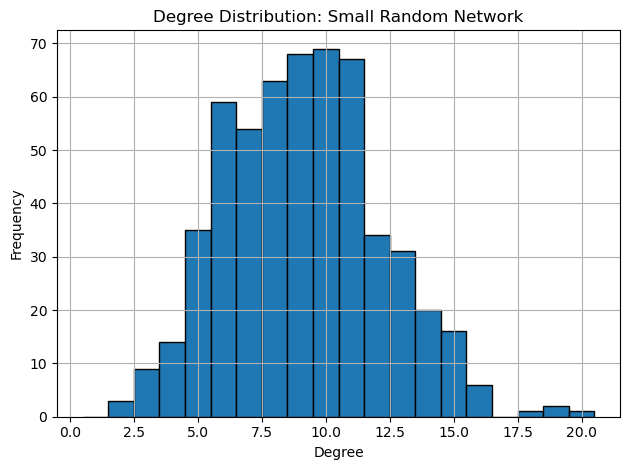

In [79]:
plot_degree_distribution(small_random_network_metrics["degree_sequence"],"Small Random Network")

#### Degree Distribution Comparison: Small Wikidata Editor Network vs Small Random Network

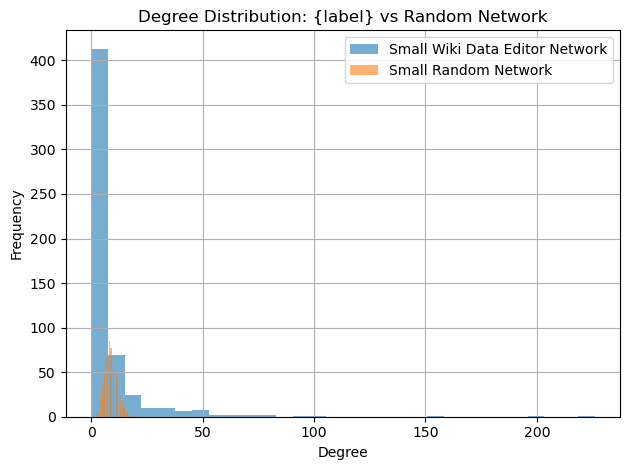

In [69]:
plot_degree_distribution_comparison(small_graph_metrics["degree_sequence"],
                                    small_random_network_metrics["degree_sequence"],
                                    "Small Wiki Data Editor Network",
                                    "Small Random Network")

### Comparison: Medium Wikidata Editor Network vs Random Network

We compare the medium-sized Wikidata editor network with a random network generated using the Erdos-Renyi model. Both networks have the same number of nodes and approximately the same number of edges.

#### Computing and Displaying Medium Wikidata Editor Network Metrics

In [ ]:
medium_graph_metrics = compute_network_metrics(medium_size_graph_network) 
display_metrics(medium_graph_metrics, medium_size_graph_network, "Medium Wikidata Editor Networks" )


---------------------### Medium Wikidata Editor Networks Statistics ###---------------------
Number of nodes: 6101
Number of edges: 7252
Number of connected components: 2716
Diameter of largest component: 11
Average shortest path length: 3.6384
Average degree: 2.38
Average clustering coefficient: 0.1551

Centrality Measures:

Degree Centrality:
[0.08311, 0.06541, 0.04607, 0.03508, 0.03246, 0.0282, 0.02311, 0.02049, 0.01967, 0.01721]

Closeness Centrality:
[0.25106, 0.23693, 0.22445, 0.21561, 0.21288, 0.21204, 0.21126, 0.21076, 0.21028, 0.20546]

Betweenness Centrality:
[0.0868, 0.05969, 0.04459, 0.03171, 0.0242, 0.02223, 0.01663, 0.01402, 0.01233, 0.01038]

Sample Node: 2875
Attributes: {'username': 'Jacob&#39;s Crackers', 'total_comments': 1, 'unique_pages': 1, 'unique_threads': 1}

------------------------------------------------------------------------------


#### Computing and Displaying Medium Random Network Metrics

In [82]:
medium_random_network = generate_random_network(medium_size_graph_network)
medium_random_network_metrics = compute_network_metrics(medium_random_network)
display_metrics(medium_random_network_metrics, medium_random_network, "Medium Random Network Statistics")


---------------------### Medium Random Network Statistics Statistics ###---------------------
Number of nodes: 6101
Number of edges: 7315
Number of connected components: 618
Diameter of largest component: 21
Average shortest path length: 9.5500
Average degree: 2.40
Average clustering coefficient: 0.0000

Centrality Measures:

Degree Centrality:
[0.00164, 0.00148, 0.00148, 0.00148, 0.00148, 0.00148, 0.00131, 0.00131, 0.00131, 0.00131]

Closeness Centrality:
[0.12061, 0.11894, 0.11763, 0.11714, 0.1171, 0.11633, 0.11582, 0.11571, 0.11536, 0.11513]

Betweenness Centrality:
[0.01845, 0.01316, 0.01175, 0.01167, 0.01141, 0.01112, 0.01096, 0.0108, 0.01074, 0.01061]

Sample Node: 0
Attributes: {}

------------------------------------------------------------------------------


#### Degree Distribution: Medium Wikidata Editor Network

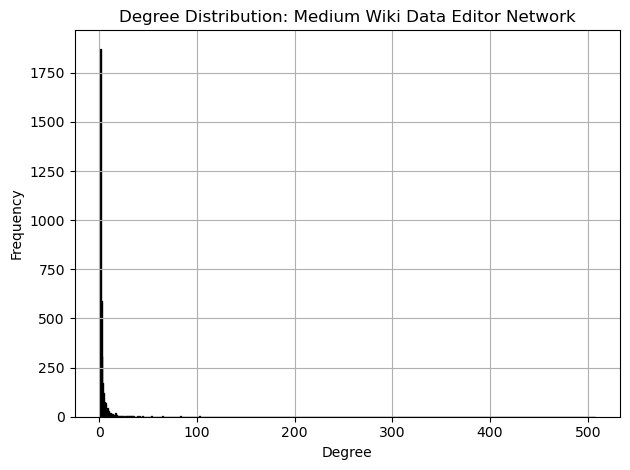

In [83]:
plot_degree_distribution(medium_graph_metrics["degree_sequence"],"Medium Wiki Data Editor Network")

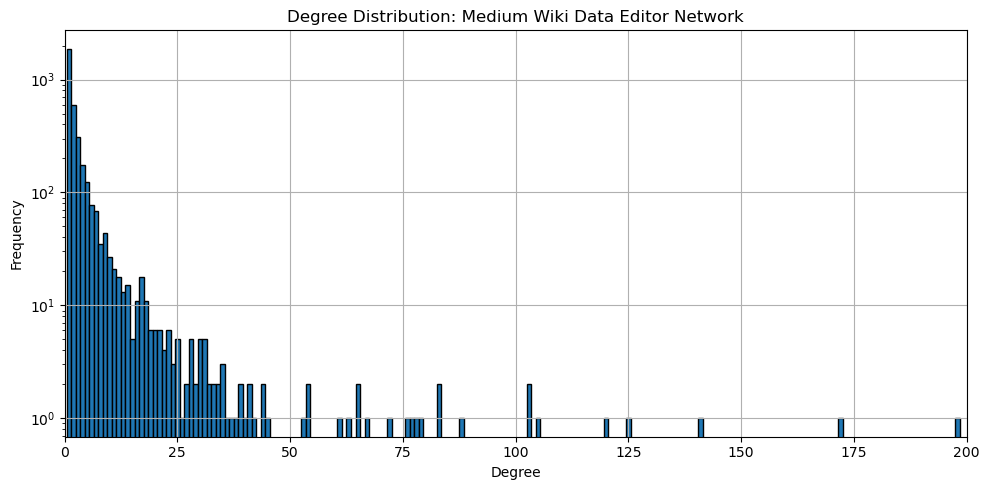

In [112]:
plot_degree_distribution_logarithmic(medium_graph_metrics["degree_sequence"],
                        label="Medium Wiki Data Editor Network",
                        log_y=True, max_degree=200)

#### Degree Distribution: Medium Random Network

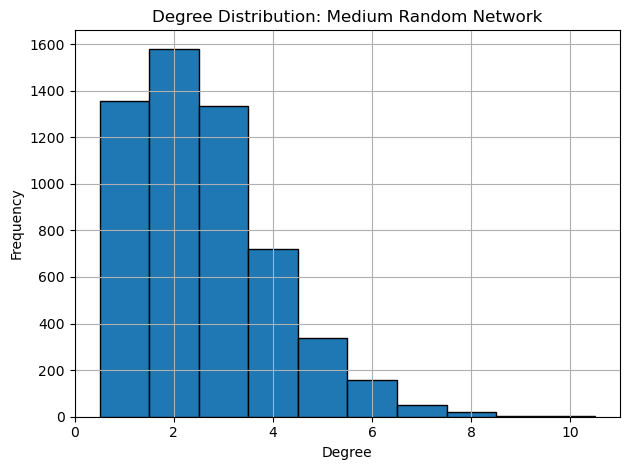

In [84]:
plot_degree_distribution(medium_random_network_metrics["degree_sequence"],"Medium Random Network")

#### Degree Distribution Comparison: Medium Wikidata Editor Network vs Medium Random Network

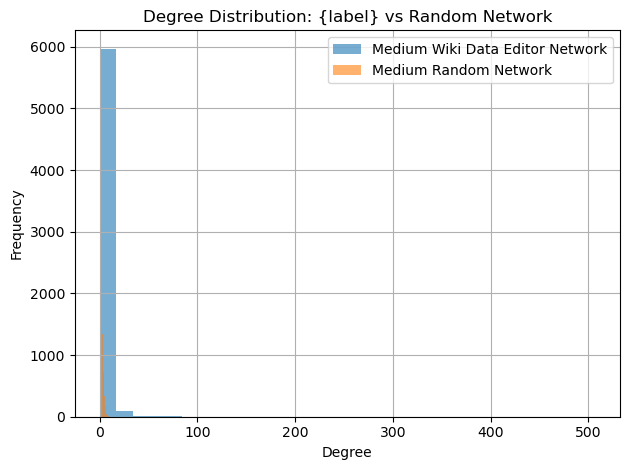

In [85]:
plot_degree_distribution_comparison(medium_graph_metrics["degree_sequence"],
                                    medium_random_network_metrics["degree_sequence"],
                                    "Medium Wiki Data Editor Network",
                                    "Medium Random Network")

### Comparison: Large Wikidata Editor Network vs Random Network

We compare the large-sized Wikidata editor network with a random network generated using the Erdos-Renyi model. Both networks have the same number of nodes and approximately the same number of edges.

#### Computing and Displaying Large Wikidata Editor Network Metrics

In [86]:
large_graph_metrics = compute_network_metrics(large_size_graph_network) 
display_metrics(large_graph_metrics, large_size_graph_network, "Large Wikidata Editor Networks" )


---------------------### Large Wikidata Editor Networks Statistics ###---------------------
Number of nodes: 9935
Number of edges: 33488
Number of connected components: 57
Diameter of largest component: 6
Average shortest path length: 2.7022
Average degree: 6.74
Average clustering coefficient: 0.3919

Centrality Measures:

Degree Centrality:
[0.49718, 0.43839, 0.1216, 0.07167, 0.07117, 0.06443, 0.06352, 0.05738, 0.05184, 0.05073]

Closeness Centrality:
[0.56454, 0.54102, 0.52475, 0.51033, 0.50478, 0.50421, 0.49961, 0.49938, 0.49936, 0.4985]

Betweenness Centrality:
[0.50825, 0.45897, 0.06178, 0.02544, 0.02516, 0.02379, 0.01614, 0.01559, 0.01494, 0.01484]

Sample Node: 4710
Attributes: {'username': 'Richard Arthur Norton (1958- )', 'total_comments': 165, 'unique_pages': 89, 'unique_threads': 158}

------------------------------------------------------------------------------


#### Computing and Displaying Large Random Network Metrics

In [87]:
large_random_network = generate_random_network(large_size_graph_network)
large_random_network_metrics = compute_network_metrics(large_random_network)
display_metrics(large_random_network_metrics, large_random_network, "Large Random Network Statistics")


---------------------### Large Random Network Statistics Statistics ###---------------------
Number of nodes: 9935
Number of edges: 33446
Number of connected components: 10
Diameter of largest component: 9
Average shortest path length: 5.0419
Average degree: 6.73
Average clustering coefficient: 0.0008

Centrality Measures:

Degree Centrality:
[0.00201, 0.00191, 0.00191, 0.00181, 0.00181, 0.00181, 0.00181, 0.00171, 0.00171, 0.00171]

Closeness Centrality:
[0.22783, 0.22739, 0.22559, 0.22391, 0.22386, 0.22368, 0.22367, 0.22357, 0.22338, 0.22322]

Betweenness Centrality:
[0.003, 0.00269, 0.00264, 0.00258, 0.00246, 0.00244, 0.00238, 0.00232, 0.00223, 0.00218]

Sample Node: 0
Attributes: {}

------------------------------------------------------------------------------


#### Degree Distribution: Large Wikidata Editor Network

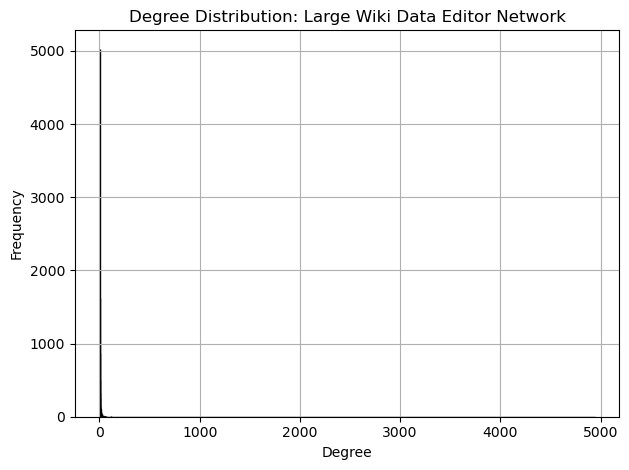

In [88]:
plot_degree_distribution(large_graph_metrics["degree_sequence"],"Large Wiki Data Editor Network")

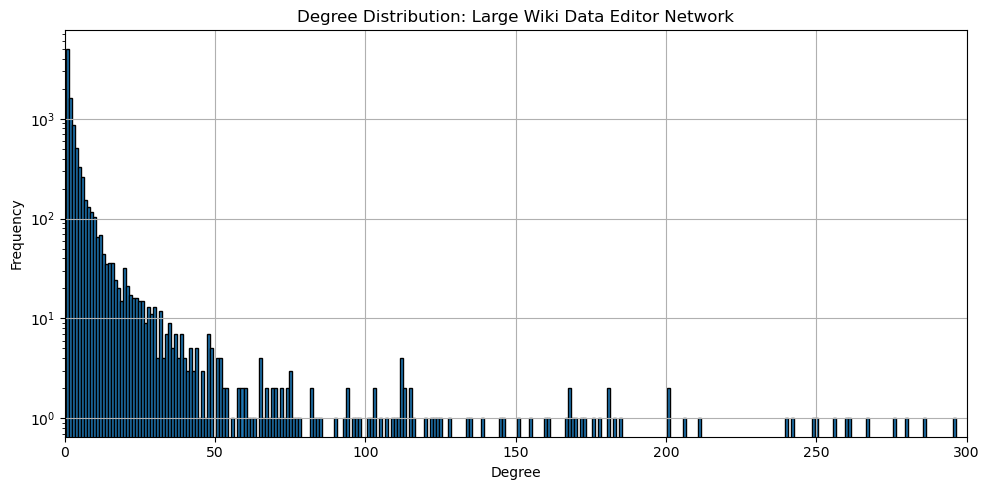

In [111]:
plot_degree_distribution_logarithmic(large_graph_metrics["degree_sequence"],
                        label="Large Wiki Data Editor Network",
                        log_y=True, max_degree=300)

#### Degree Distribution: Large Random Network

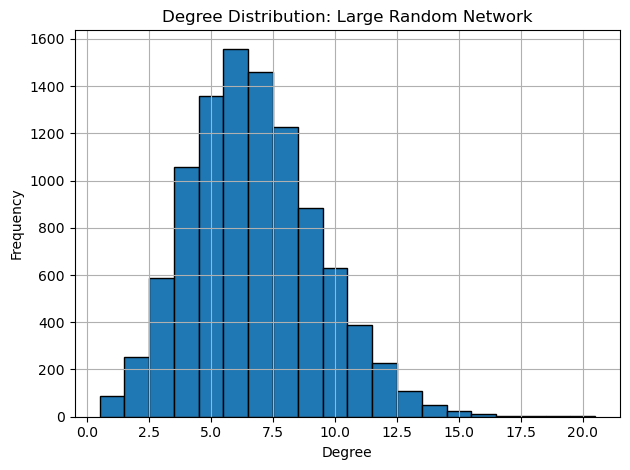

In [89]:
plot_degree_distribution(large_random_network_metrics["degree_sequence"],"Large Random Network")

#### Degree Distribution Comparison: Large Wikidata Editor Network vs Large Random Network

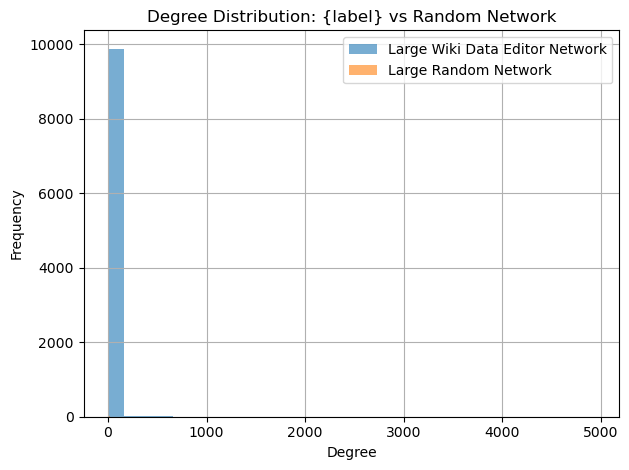

In [90]:
plot_degree_distribution_comparison(large_graph_metrics["degree_sequence"],
                                    large_random_network_metrics["degree_sequence"],
                                    "Large Wiki Data Editor Network",
                                    "Large Random Network")

## Task C

## Task D